# Guy Gaash & Michael Rubinfeld Fianl project 
#### The process of building and evaluating the model which will be used in the final algorithm

In [ ]:
import pandas as pd
import re 
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords', quiet = True)
import warnings
warnings.filterwarnings('ignore')

### Data Cleaning
##### Data Normalization and cleaning is arguably the most important part of traiinng an NLP model. The model will always be as good as the normalization process. The following normalizing function is the result of a long and meticulous process of understanding the data to its core, and finding patterns in it. 

##### Twitch chat messages are messy, unexpectable and poorly formed gramatically. A good normalizer is key to tackle this challenge.

In [ ]:
def clean_data(path):

    # initial cleaning and formatting for the preprocessing phase
    df = pd.read_excel(path).dropna()
    df = df.applymap(str)
    df.loc[~df.label.isin(['yes', 'no']), 'label'] = 'no'

    # check the label for mistakes
    if df['label'].isna().sum() > 0:
        raise Exception("Missing value in the label column, please correct it")
    if df['label'].nunique() != 2:
        raise Exception("Typo in one or more of the label values")

    # we have to remove emojis first because some words have emojis in the middle of them
    def remove_emojis(text):
        return text.encode("ascii", "ignore").decode()

    def remove_numbers(text):
        return ''.join([i for i in text if not text.isdigit()])

    # we don't lower case all words because some words in all-cap will be classified as hype while otherwise won't
    # be. But, normal words who start with an uppercase letter and normal words who are all lower have no difference
    # in sentiment for us. In this case we normalize to reduce unnecessary noise in the corpus
    def normalize_titles(text):
        return ' '.join(word.lower() if word.istitle() else word for word in text.split())

    def english_shortcut_corrections(text):
        ###### first replace chars which are prefixes or suffixes of words so the other corrections will catch all cases
        text = text.replace('\x01', '')
        text = text.replace('!', ' ! ')
        text = text.replace('?', ' ? ')
        ######
        text = text.replace(r"kekw", "KEKW")
        text = text.replace(r"POG", "pog")
        text = text.replace(r"POGGERS", "pog")
        text = text.replace(r"poggers", "pog")
        text = text.replace(r"POGCHAMP", "pog")
        text = text.replace(r"pogchamp", "pog")
        text = text.replace(r"noice", "nice")
        text = text.replace(r"NICE", "nice")
        text = text.replace(r"damn", "DAMN")
        text = text.replace(r"lmao", "LMAO")
        text = text.replace(r"'s", " is")
        text = text.replace(r"ive", "I have")
        text = text.replace(r"didnt", "did not")
        text = text.replace(r"heyy", "hey")
        text = text.replace(r"'ve", " have")
        text = text.replace(r"can't", "cannot")
        text = text.replace(r"cant", "cannot")
        text = text.replace(r"musn't", "must not")
        text = text.replace(r"you're", "you are")
        text = text.replace(r"youre", "you are")
        text = text.replace(r"they're", "they are")
        text = text.replace(r"theyre", "they are")
        text = text.replace(r"HYPE", " hype ")
        text = text.replace(r"hype", " hype ")
        text = text.replace(r"ezy", "EZ")
        text = text.replace(r"ez", "EZ")
        text = text.replace(r"EZY", "EZ")
        text = text.replace(r"yup", "yes")
        text = text.replace(r"nvm", "nevermind")
        text = text.replace(r"n't", " not")
        text = text.replace(r"i'm", "I am")
        text = text.replace(r"im", "I am")
        text = text.replace(r"IM", "I am")
        text = text.replace(r"Im", "I am")
        text = text.replace(r"I'm", "I am")
        text = text.replace(r"'re", " are")
        text = text.replace(r"'d", " would")
        text = text.replace(r"\'ll", " will")
        text = text.replace(r"I'm", "I am")
        text = text.replace(r"em", "them")
        text = text.replace(r"omg", "OMG")
        text = text.replace(r"GG", "gg")
        text = text.replace(r"ggs", "gg")
        text = text.replace(r"GGs", "gg")
        text = text.replace(r"GGS", "gg")
        text = text.replace(r"UL", "LUL")
        text = text.replace(r"LU", "LUL")
        text = text.replace(r"Playstream", "playstream")
        text = text.replace(r"Playstream.gg", "playstream")
        text = text.replace(r"playstrema", "playstream")
        text = text.replace(r"laystream", "playstream")
        text = text.replace(r"playstrea", "playstream")
        text = text.replace(r"Playstrea", "playstream")

        return text

    # user tags start with an '@', needs to be removed
    def remove_user_tags(text):
        return ' '.join(word for word in text.split() if word[0] != '@')

    def remove_URL(text):
        url = re.compile('https?://\s+|www\.\s+')
        return url.sub('', text)

    # sometimes "action" words are stuck together with other words so we seperate them. example: "goHYPE"
    def seperate_action_words(text):
        for i in range(1, len(text)):
            if (text[i - 1].islower() and text[i].isupper()) or (text[i - 1].isupper() and text[i].islower()):
                text = text[:i] + ' ' + text[i:]
        return text

    # relevant punctuations: whitespace, exclamation-mark and question-mark
    def remove_irrelevant_punctuations(text):
        return re.sub(pattern='[^\w\s\!\?]', repl='', string=text)

    # almost last to limit noise in the text so the function will successfully lemmatize most words
    def stem_words(text):
        words = text.split()
        stemmer = SnowballStemmer(language = 'english')
        stemmed_text = ''
        for word in words:
            x = stemmer.stem(word)
            stemmed_text += x + ' '
        return stemmed_text.rstrip()

    # saved for last because the text has to be as clean as possible for this function to catch the most stopwords
    def remove_stopwords(text):
        stop_words = set(stopwords.words('english'))
        return ' '.join(word for word in text.split() if word.lower() not in stop_words)

    # some words represent excitement but are varying in length, for example: "Goooo" is the same as "Goo"
    # and we need to normalize that since words of those kind always represent hype
    # words are: "Goo...", "goo...", "Hahaha...", "hahahaha..." and more.
    def normalize_hype_indicators_with_trailings(text):
        for word in text.split():
            if word[:2] in ['Go', 'go', 'GO'] and word[-1] in ['O', 'o']:
                text = text.replace(word, 'GO')
            if word[:2] in ['ha', 'Ha', 'HA'] and word[-1] in ['A', 'a']:
                text = text.replace(word, 'HAHA')
            if word[:3] in ['LMA', 'lma'] and word[-1] in ['O', 'o']:
                text = text.replace(word, 'LMAO')
            if word[:3] in ['SHE', 'she'] and word[-1] in ['H', 'h']:
                text = text.replace(word, 'SHEESH')
            if word[:3] in ['NIC', 'Nic', 'nic'] and word[-2:] in ['EE', 'ee']:
                text = text.replace(word, 'nice')
            if word[:3] in ['OMG', 'Omg', 'omg'] and word[-2:] in ['GG', 'gg']:
                text = text.replace(word, 'omg')
        return text

    # apply all functions (order is important) and after strip leftover whitspaces
    df['content'] = df.content.map(lambda x: remove_emojis(x))
    df['content'] = df.content.map(lambda x: remove_numbers(x))
    df['content'] = df.content.map(lambda x: normalize_titles(x))
    df['content'] = df.content.map(lambda x: english_shortcut_corrections(x))
    df['content'] = df.content.map(lambda x: remove_user_tags(x))
    df['content'] = df.content.map(lambda x: remove_URL(x))
    df['content'] = df.content.map(lambda x: seperate_action_words(x))
    df['content'] = df.content.map(lambda x: remove_irrelevant_punctuations(x))
    df['content'] = df.content.map(lambda x: stem_words(x))
    df['content'] = df.content.map(lambda x: remove_stopwords(x))
    df['content'] = df.content.map(lambda x: normalize_hype_indicators_with_trailings(x))
    df['content'] = df.content.map(lambda x: x.strip())

    # at the end of the preprocessing functions run, some boxes in the dataframe will be left empty so we
    # will remove the entire row since it's not relevant anymore
    df = df[df['content'] != ' ']
    df = df[df['content'] != '']
    df = df.dropna()

    # turn label to numerical
    df['label'] = df['label'].replace({'yes': 1, 'no': 0, 'no ': 0})
    
    return df

In [ ]:
df = clean_data("data_feb_20.xlsx")
print(df.head(10))

           timestamp      name                        content  label
0   11/16/2021 15:05    kifkaf                 late get bulli      0
1   11/16/2021 15:06   ishmahl                          trust      0
2   11/16/2021 15:07   ishmahl                        sorri ?      0
4   11/16/2021 15:08  nightbot  readi build next pc live http      0
5   11/16/2021 15:08   ishmahl             dont think discord      0
6   11/16/2021 15:08   ishmahl                        put one      0
7   11/16/2021 15:09   ishmahl                     understand      0
8   11/16/2021 15:09   ishmahl                      ok anyway      0
9   11/16/2021 15:09   ishmahl              4 assign due week      0
10  11/16/2021 15:09   ishmahl                          uhhhh      0


### EDA

Let's have a look at the binary label

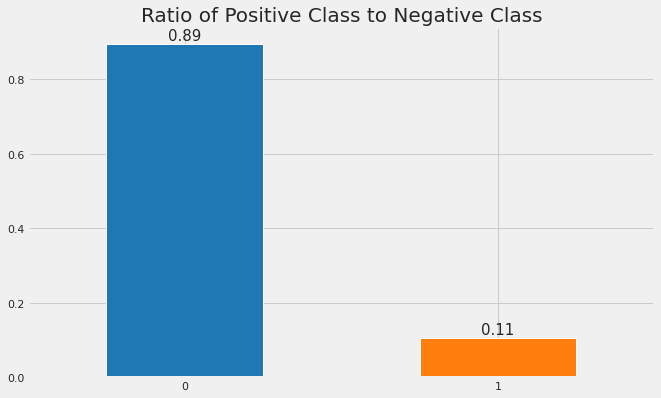

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.title('Ratio of Positive Class to Negative Class', fontsize=20)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# make a list of the amount of each category's representation
counts = df['label'].value_counts().tolist()

# make a list of the precentages of the representations
precs = []
for count in counts:
    precs.append(count / len(df))

# plot the representations
bars = df['label'].value_counts() / len(df)
sns.set(style="darkgrid")
ax = bars.plot(kind = 'bar', color = colors)
plt.xticks(rotation=360)
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2,
                p.get_height()), ha='center', va='center',
                size=15, xytext=(0, 8),
                textcoords='offset points')

We see here that the negative class is a majority class. This means that ontop of this NLP problem we have an imbalanced data problem.

Let's see what kind of data we have in our minority class:

Text(0.5, 1.0, 'Most Common Expressions in Hype messages')

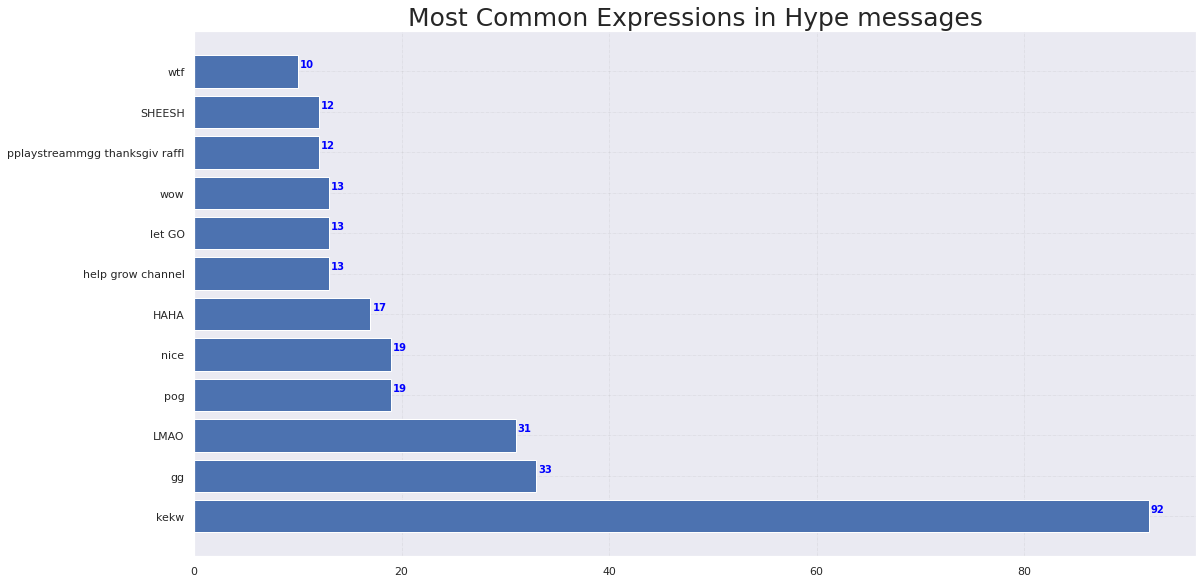

In [ ]:
from collections import Counter
import numpy as np

df_hype = df.loc[df['label'] == 1]
counts = Counter(df_hype['content'])
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1][:12]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indecies = np.arange(len(labels))

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(labels, values, align = 'center')

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='blue')
    
plt.title('Most Common Expressions in Hype messages', fontsize=25)

We see that we have a few "regular expressions" which represent hype which most of them are streamer lingo ("kekw", "pog", "sheesh"...). The model will probably learn those expressions and strongly connect them with hype.

Let's zoom in to the world level and see which are the most prevalent: 

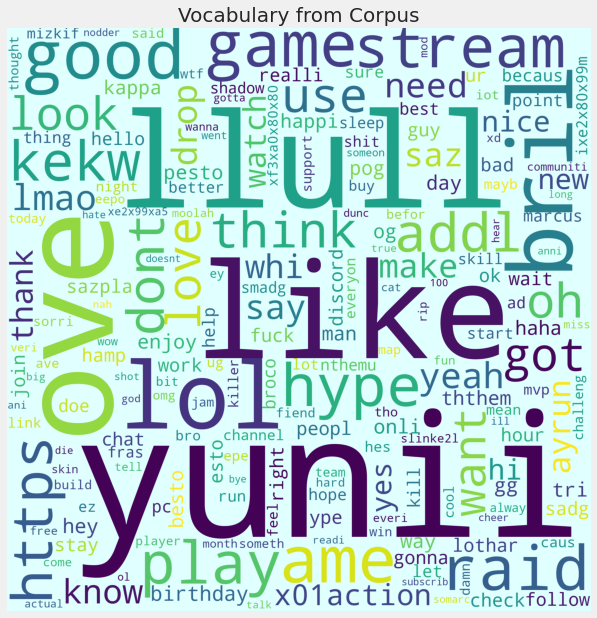

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df['content'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Corpus", fontsize = 20)
plt.show()

On the word level on the contrary to the expression level - there is a lot of noise and disorder in the data.

### Model Building


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size = 0.2,
                                                    stratify = df['label'].values, random_state = 42)

#### TF-IDF configs

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score, make_scorer
import numpy as np

char_level = [False]
lowercase = [False]
preprocessor = [None]
stop_words = [None]

ngram_min, ngram_max = 1, 3
ngrams_start_from_one, use_idf = ([True, False],) * 2

def log_range(lower, upper, samples_per_decade, is_int=True):
    samples = 1 + (upper - lower) * samples_per_decade
    samples = int(round(samples))
    if is_int:
        return [int(round(i)) for i in np.logspace(lower, upper, samples)]
    else:
        return list(np.logspace(lower, upper, samples))

min_dfs_logrange = (0, 2, 1)

if type(use_idf) is bool:
    use_idf = [use_idf]
if type(ngrams_start_from_one) is bool:
    ngram_min_max_pairs = [(1 if ngrams_start_from_one else n, n) \
                           for n in range(ngram_min, ngram_max + 1)]
else:
    ngram_min_max_pairs = [(1, n) for n in range(ngram_min, ngram_max + 1)]
    # The next one starts from 2 because if it's one it's aleady
    # included in the previous line
    ngram_min_max_pairs += [(n, n) for n in range(max(2, ngram_min), \
                                                  ngram_max + 1)]

print(f"The ngram ranges are: {ngram_min_max_pairs}")

The ngram ranges are: [(1, 1), (1, 2), (1, 3), (2, 2), (3, 3)]


Parameters grid which will be the options fo parameters through all the model pipelines:

In [ ]:
Tfidf_params = {'feature_extractor': [TfidfVectorizer()],
         'feature_extractor__ngram_range': ngram_min_max_pairs,
         'feature_extractor__use_idf': use_idf,
         'feature_extractor__norm': ['l2'],
         'feature_extractor__min_df': log_range(*min_dfs_logrange),
         'feature_extractor__preprocessor': preprocessor,
         'feature_extractor__stop_words': stop_words,
         'feature_extractor__lowercase': lowercase,
         'feature_extractor__analyzer': ['word']
               }

In [ ]:
# Helper function and object to be used throughout the process
from sklearn.model_selection import StratifiedKFold
def Merge (dict1, dict2):
  d = {**dict1, **dict2}
  return d

splitter = StratifiedKFold(3, shuffle=True, random_state = 42)

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

reg_coef_logrange = (0, 3, 10)
lr_params = {'model': [LogisticRegression()],
         'model__random_state': [42],
         'model__C': log_range(*reg_coef_logrange, is_int=False),
         'model__solver': ['lbfgs', 'liblinear'],
         'model__max_iter': [int(1e6)],
         'model__class_weight': ['balanced']
         }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

full_lr_params = Merge(Tfidf_params, lr_params)

lr_pipeline = Pipeline([
    ('feature_extractor', TfidfVectorizer()),
    ('scaler', 'passthrough'),
    ('model', LogisticRegression())
])

lr_rs = RandomizedSearchCV(estimator = lr_pipeline, param_distributions = full_lr_params, n_iter = 100,
                           scoring = 'roc_auc', n_jobs = -1, cv = splitter, verbose = 2)

lr_rs.fit(X_train, y_train)
warnings.filterwarnings('ignore')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
print(f'Best Score:\n{lr_rs.best_score_}\n')
print(f'Best Params:\n{lr_rs.best_params_}')

Best Score:
0.8893339391780032

Best Params:
{'model__solver': 'lbfgs', 'model__random_state': 42, 'model__max_iter': 1000000, 'model__class_weight': 'balanced', 'model__C': 1.9952623149688797, 'model': LogisticRegression(C=1.9952623149688797, class_weight='balanced',
                   max_iter=1000000, random_state=42), 'feature_extractor__use_idf': True, 'feature_extractor__stop_words': None, 'feature_extractor__preprocessor': None, 'feature_extractor__norm': 'l2', 'feature_extractor__ngram_range': (1, 3), 'feature_extractor__min_df': 1, 'feature_extractor__lowercase': False, 'feature_extractor__analyzer': 'word', 'feature_extractor': TfidfVectorizer(lowercase=False, ngram_range=(1, 3))}


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {'model': [RandomForestClassifier()],
                'model__random_state': [42],
                'model__n_estimators': [200],
                'model__min_samples_split': [2, 3, 4, 5, 6], 
                'model__min_samples_leaf': [1, 2, 3],
                'model__max_features': ['auto', 1/3, 'sqrt', 'log2'],
                'model__criterion' : ['entropy'],
                'model__class_weight': ['balanced']}

full_rf_params = Merge(Tfidf_params,rf_params)

rf_pipeline = Pipeline([
    ('feature_extractor', TfidfVectorizer()),
    ('scaler', 'passthrough'),
    ('model', RandomForestClassifier())
])


rf_rs = RandomizedSearchCV(estimator = rf_pipeline, param_distributions = full_rf_params, n_iter = 30,
                           scoring = 'roc_auc', n_jobs = -1, cv = splitter, verbose = 2)

rf_rs.fit(X_train, y_train)
warnings.filterwarnings('ignore')

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [ ]:
print(f'Best Score:\n{rf_rs.best_score_}\n')
print(f'Best Params:\n{rf_rs.best_params_}')

Best Score:
0.8791729098937692

Best Params:
{'model__random_state': 42, 'model__n_estimators': 200, 'model__min_samples_split': 6, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__criterion': 'entropy', 'model__class_weight': 'balanced', 'model': RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=6, n_estimators=200, random_state=42), 'feature_extractor__use_idf': True, 'feature_extractor__stop_words': None, 'feature_extractor__preprocessor': None, 'feature_extractor__norm': 'l2', 'feature_extractor__ngram_range': (1, 3), 'feature_extractor__min_df': 1, 'feature_extractor__lowercase': False, 'feature_extractor__analyzer': 'word', 'feature_extractor': TfidfVectorizer(lowercase=False, ngram_range=(1, 3))}


#### Ensemble Method

###### An attempt to utilize both classifiers and use them in an ensemble model which may be better than both.

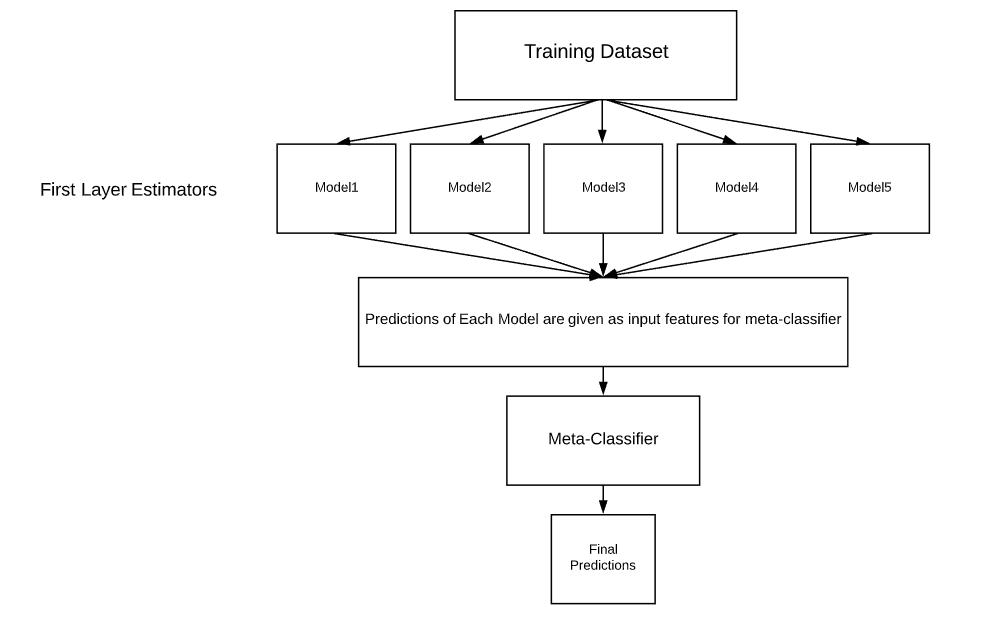

In [ ]:
from sklearn.ensemble import StackingClassifier

best_lr = lr_rs.best_estimator_
best_rf = rf_rs.best_estimator_
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', best_lr))
	level0.append(('rf', best_rf))

	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=2)
	return model

In [ ]:
def get_models():
    models = dict()
    models['lr'] = best_lr
    models['rf'] = best_rf
    models['stacking'] = get_stacking()
    return models

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>lr 0.8895008575276717 (0.005822258570952812)
>rf 0.8839565246120669 (0.0072665966424948665)
>stacking 0.8926868581327321 (0.006783157998044835)


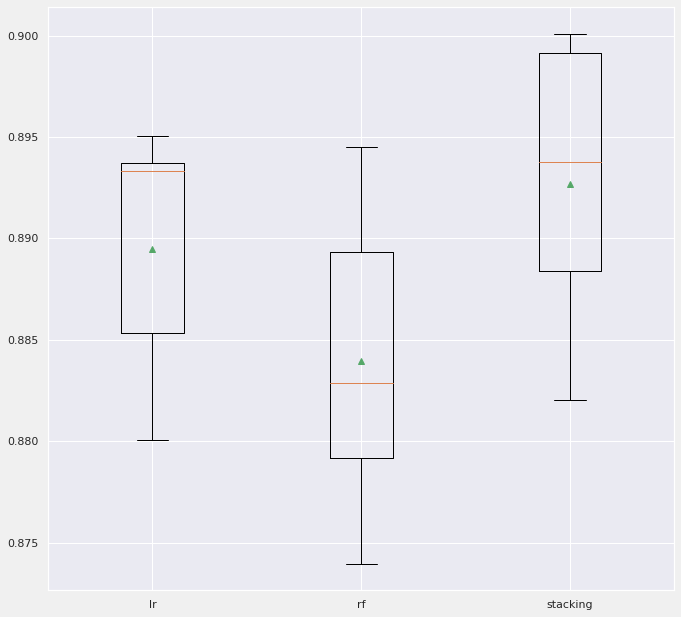

In [ ]:
### get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(f'>{name} {scores.mean()} ({scores.std()})')

# plot model performance for comparison
plt.figure(figsize=(10,10))
sns.set(style="darkgrid")
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

###### The Ensemble model seems to outperform both regular models. Let's test it and get final AUC score

### Final model evaluation
###### In the final part, we would like to build a system which will check the actual AUC of the model. The model is "hybrid" in a sense the prediction combines rule-based criteria and the model's prediction itself.

First let's build the rule based function which will be used for the final prediciton block.

In [ ]:
final_model = get_stacking()

def is_mostly_emoji(message):
    # check if message is only emojis (2 extra mistake chars from user are allowed)
    return len(message.encode("ascii", "ignore").decode()) < 3


def is_hype_inferred_from_char_types(message):
    # we have concluded that if a message is more than 50% uppercase letters, or contains at least 2 exclamation
    # points or question marks, it hype.
    len_message = len(message)
    uppercase_count = exclamation_point_count = question_mark_count = 0
    for char in message:
        if char.isupper():
            uppercase_count += 1
        if char == '!':
            exclamation_point_count += 1
        if char == '?':
            question_mark_count += 1
        if (uppercase_count / len_message >= 0.5) or exclamation_point_count == 2 or question_mark_count == 3:
            return True
    return False


def rule_based_hype_predictor(message):
    if is_mostly_emoji(message):
        return True
    if is_hype_inferred_from_char_types(message):
        return True

    ### checking if streamer is tagged is problematic in this case, we'll have
    ### to do without...

    return False

In [ ]:
final_model.fit(X_train, y_train)
warnings.filterwarnings('ignore')

This is the prediction block, in which if hype is not detected by the rule-based criteria, it goes into the model for prediction.

In [ ]:
def predict_hybrid_model(model, test_set, method):
  if method == 'predict':
    y_hat = model.predict(test_set)
  elif method == 'predict_proba':
    y_hat = model.predict_proba(test_set)
  else:
    raise(ValueError)
    
  try:
    test_set = test_set.tolist()
  except:
    pass

  for i in range(len(test_set)):
    if (y_hat[i] < 0.5).all() and (rule_based_hype_predictor(test_set[i])).all():
      y_hat[i] = 1

  return np.array(y_hat)

Now that we have our final prediction method let's see what will be our model's expected AUC in production:

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from numpy import interp
warnings.filterwarnings('ignore')

def KfoldPlot(X, y, clf, k):
    
    # save classifier model name for the ROC plt
    clf_name = str(clf)[:str(clf).find("(")]    
    
    # initialize empty figure
    plt.figure(figsize=(10,6))
    
    # initialize the k-fold object
    kf = StratifiedKFold(k, shuffle=False)

    # initialize the interpolation of the data
    mean_fpr = np.linspace(0, 1, 100)
    
    # initialize lists containing the the tprs and aucs for each fold
    tprs, aucs = [], []
    i=1
    for train_index, validation_index in kf.split(X, y):
        
        # building a model for the current fold
        model = clf.fit(X[train_index], y[train_index])
        
        # predicting probabilities on the validation data based on the model trained on the training data
        prediction = predict_hybrid_model(model, X[validation_index], 'predict_proba')
        
        # getting the postive rates and the thresholds for the roc curve - validation data vs. prediction data
        fpr, tpr, thresholds = roc_curve(y[validation_index], prediction[:,1])
        
        # interpolating them so all of the classifiers will be working under the same thersholds, adding to tpr list
        tprs.append(interp(mean_fpr, fpr, tpr))
        
        # calculating the auc for the current roc_curve
        roc_auc = auc(fpr, tpr)
        
        # appending the current auc to the auc list
        aucs.append(roc_auc)
        
        # plotting the roc curve for the current fold
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        
        # keeping track of the folds with i
        i += 1
        
    # plotting the random guess line
    plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
    
    # calculating the mean tpr and mean auc from the data gathered during the loop
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    
    # plotting the mean roc line making it bolder than the rest
    plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.3f )' % (mean_auc), lw=2, alpha=1)

    # labels and stuff
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + clf_name)
    plt.legend(loc="lower right")
    plt.show()

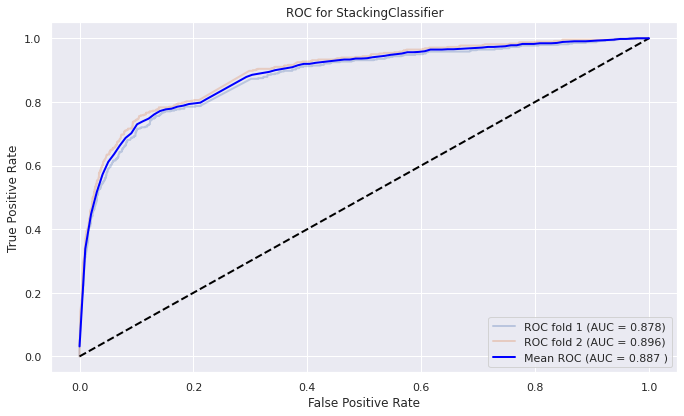

In [ ]:
KfoldPlot(X_train.values, y_train.values, get_stacking(), 10)

###### Final test AUC score

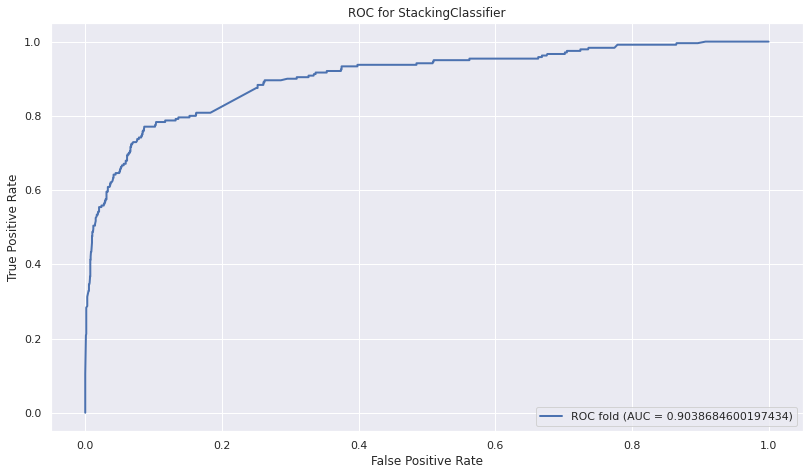

In [ ]:
plt.figure(figsize=(12,7))
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

# predicting probabilities on the validation data based on the model trained on the training data
prediction = predict_hybrid_model(final_model, X_test, 'predict_proba')

# getting the postive rates and the thresholds for the roc curve - validation data vs. prediction data
fpr, tpr, thresholds = roc_curve(y_test, prediction[:,1])

# interpolating them so all of the classifiers will be working under the same thersholds, adding to tpr list
tprs.append(interp(mean_fpr, fpr, tpr))

# calculating the auc for the current roc_curve
roc_auc = auc(fpr, tpr)

# appending the current auc to the auc list
aucs.append(roc_auc)

# plotting the roc curve for the current fold
plt.plot(fpr, tpr, lw=2, alpha=1, label=f'Test AUC = {roc_auc}')

# labels and stuff
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC for ' + str(final_model)[:str(final_model).find("(")] )
plt.legend(loc="lower right")
plt.show()